<a id = "pymc3"></a>

### Extension: MCMC Techniques with `pymc3`

`PyMC` is a useful module to know for reasons beyond Bayesian Linear Regression, given its implementation of MCMC.   


Instead of solving our Bayesian Regression problem directly, `pymc3` instead uses Markov Chain Monte Carlo techniques to estimate regression parameters.  

You may notice different results between this technique and the solutions found above; much of those differences come from the definition of priors.  

#### `pymc3`
Two examples are given below.

First, a synthetic data-set is created, where a linear relationship is explicitly defined, and noise is added. This should give a good idea of what the parameter estimation in `pymc3` looks like.   

Second, parameters are estimated for the "housing" dataset.  

#### Reading in Housing Data:

In [1]:
### This cell imports the necessary modules and sets a few plotting parameters for display

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  

In [3]:
### Read in the data
tr_path = './train.csv'
data = pd.read_csv(tr_path)  

### The .head() function shows the first few lines of data for perspecitve
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


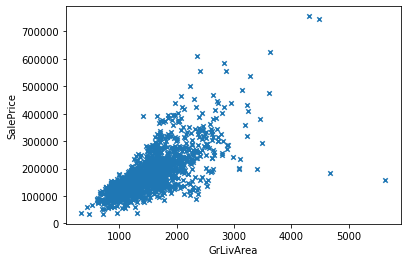

In [4]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

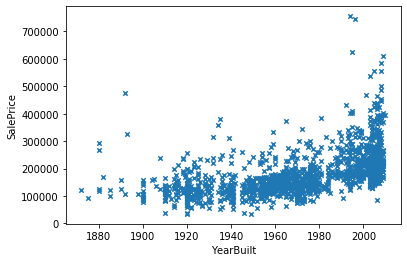

In [5]:
data.plot('YearBuilt', 'SalePrice', kind = 'scatter', marker = 'x');

#### Creating Data

Text(0.5, 1.0, 'X2 Predictor')

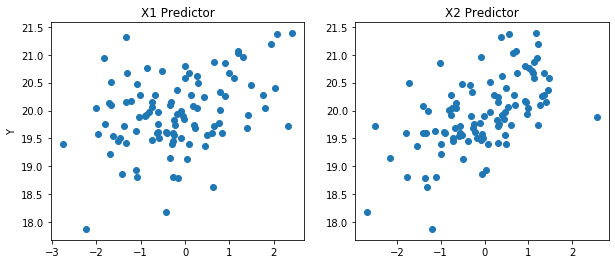

In [6]:
### Synthetic data

np.random.seed(1738)

# Create True parameters:
intercept, sigma, betas = 20, .5, np.array([0.2, .4])

# set number of observations
obs = 100

predictors = np.random.randn(obs, 2)

# Defining our explicit linear relationship. Notice how the noise is added with `sigma`
Y = intercept + np.matmul(predictors, betas) + np.random.randn(obs)*sigma


# visualize
# A view of our syntetic data, plotting both predictors against the actual values
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(predictors[:,0], Y)
plt.title("X1 Predictor")
plt.ylabel("Y")
plt.subplot(1,2,2)
plt.scatter(predictors[:,1],Y)
plt.title("X2 Predictor")

#### Using Housing Data

In [ ]:
import pymc3 as pm

# instantiate basic model
basic_model = pm.Model()

# Define two numpy arrays of predictors
X1 = predictors[:,0]
X2 = predictors[:,1]

# Tell pymc3 that everything is happening within that model
with basic_model:

    # Priors for unknown model parameters
    # Define prior for intercept as observed mean
    intercept = pm.Normal('intercept', mu=np.mean(Y), sd=10)
    
    # note shape = 2 parameter
    # prior for predictors is "0"
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    
    # Explicitly define prior for "noise" term
    sigma = pm.Normal('sigma',mu = 1, sd=1)
    
    
    # Expected relationship between variables
    mu = intercept + beta[0]*X1 + beta[1]*X2

    # Likelihood of observations
    # (sampling distribution)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    # instantiate sampler
    # `NUTS` is "no u-turn sampler", the most advanced `pymc3` offers
    step = pm.NUTS()

    # draw 500, the 5000 posterior samples
    trace_500_ex = pm.sample(500, step=step)
    trace_5k_ex = pm.sample(5000, step = step)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\jaseidel\.conda\envs\home36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, intercept]


#### Plotting the distributions of the posteriors, with both 500 and 5,000 draws.

Notice how close in both the 500 draw and 5,000 draw versions the mean "peak" of the parameters is to the actual parameters.

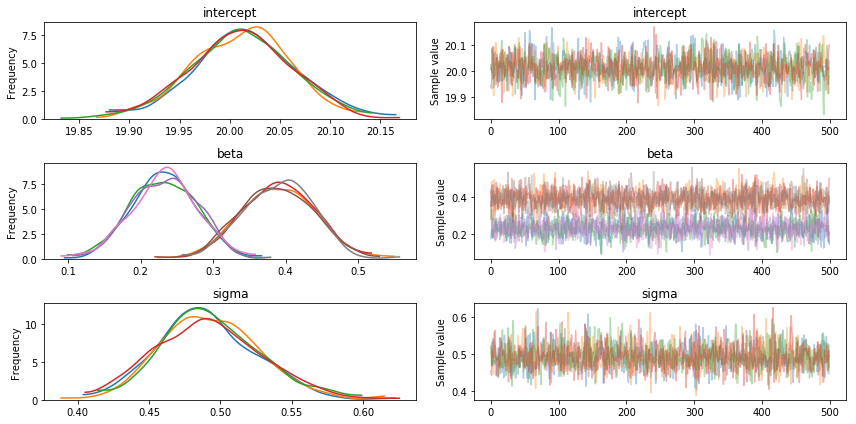

In [7]:
pm.traceplot(trace_500_ex);

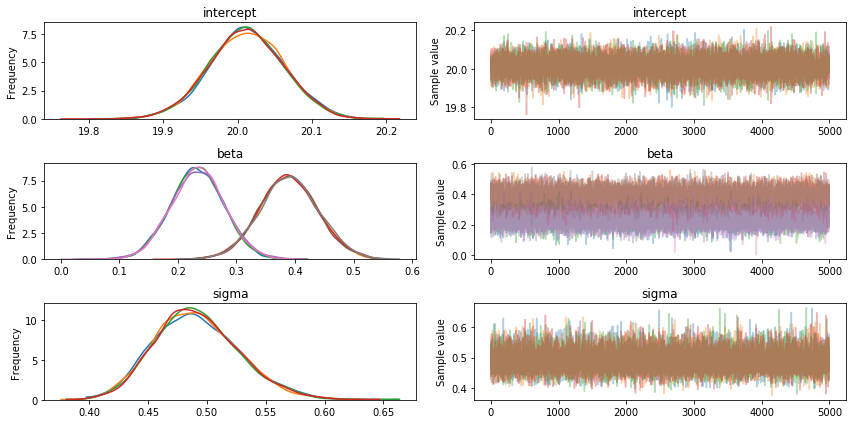

In [8]:
pm.traceplot(trace_5k_ex);

#### Finding the MAP solution

Once again, close to actual parameters

In [9]:
pm.find_MAP(model = basic_model)

logp = -74.186, ||grad|| = 0.0016684: 100%|██████████| 13/13 [00:00<00:00, 2186.46it/s]  


{'beta': array([0.23306499, 0.38918647]),
 'intercept': array(20.01145104),
 'sigma': array(0.4780666)}

#### Fitting model to housing data

In [10]:
house_model = pm.Model()
y = data.SalePrice.values
X = data[['GrLivArea','YearBuilt']].values
X1 = X[:,0]
X2 = X[:,1]

with house_model:

    # Priors for unknown model parameters
    
    # Prior for intercept is still mean of observed - different from prior used
    # in our version
    intercept = pm.Normal('intercept', mu=np.mean(y), sd=1000)
    
    # note shape = 2 parameter
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Normal('sigma',mu = 1000, sd=50)

    # Expected value of outcome
    mu = intercept + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=y)
    
    # instantiate sampler
    # Slice is a simpler sampler
    step = pm.Slice()

    # draw 500, the 5000 posterior samples
    trace_500_housing = pm.sample(500, step=step)
    trace_5k_housing = pm.sample(5000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [intercept]
100%|██████████| 1000/1000 [00:08<00:00, 113.87it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [intercept]
100%|██████████| 5500/5500 [00:17<00:00, 316.74it/s]
The number of effective samples is smaller than 10% for some parameters.


#### Plotting the distributions of the posteriors, with both 500 and 5,000 draws.

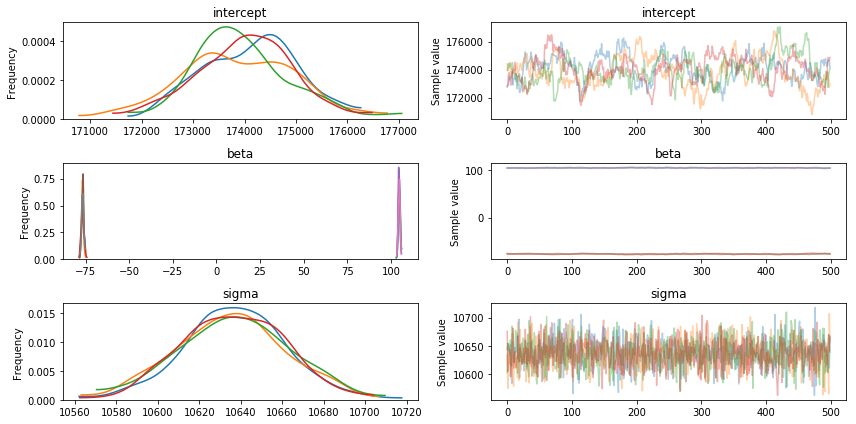

In [11]:
pm.traceplot(trace_500_housing);

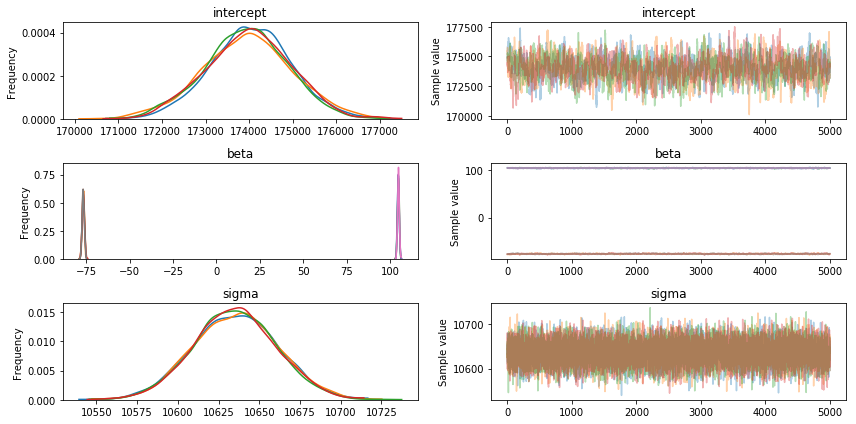

In [12]:
pm.traceplot(trace_5k_housing);

Printing out a raw observations--  

Just in case you wanted to see what they look like

In [ ]:
list(trace_500_housing.points())[:2]